In [1]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import src.data.preprocessor2 as pre
import src.data.datasets2 as data
from src.model.network import create_model, quantile_loss, create_MQDCNN, MultiQuantileLoss
from src.utils import compute_coverage_len, plot_quantiles, compute_quantile

In [3]:
import os
#in order not to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

In [47]:
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
ignore_columns = ["time", "os1", "os2", "os3"]

dataset = data.get_dataset("CMAPSS4", MinMaxScaler(feature_range=(-1, 1)))
split_dataset = pre.split_dataset(dataset, calval_size=0.2, random_state=0)
proc_dataset = pre.preprocess_split(split_dataset["train_split"], split_dataset["scaler_factory"], window_size=split_dataset["window_size"], removable_cols=removable_cols, ignore_columns=ignore_columns)


In [48]:
np.unique(proc_dataset["test"]["id"])

array([  6,   9,  13,  23,  38,  45,  46,  56,  64,  65,  74,  75,  76,
        77,  84,  90,  93,  97, 108, 110, 112, 117, 119, 126, 130, 131,
       136, 146, 151, 157, 160, 162, 163, 169, 174, 177, 179, 190, 202,
       203, 204, 208, 214, 219, 225, 227, 230, 237, 243, 249], dtype=int64)

In [49]:
np.unique(proc_dataset["train"]["id"])

array([  1,   2,   3,   4,   5,   7,   8,  10,  11,  12,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,  44,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  57,  58,  59,  60,
        61,  62,  63,  66,  67,  68,  69,  70,  71,  72,  73,  78,  79,
        80,  81,  82,  83,  85,  86,  87,  88,  89,  91,  92,  94,  95,
        96,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 111,
       113, 114, 115, 116, 118, 120, 121, 122, 123, 124, 125, 127, 128,
       129, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 147, 148, 149, 150, 152, 153, 154, 155, 156, 158, 159, 161,
       164, 165, 166, 167, 168, 170, 171, 172, 173, 175, 176, 178, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 205, 206, 207, 209, 210, 211,
       212, 213, 215, 216, 217, 218, 220, 221, 222, 223, 224, 22

In [50]:
proc_dataset["train"]["X"].shape

(45175, 15, 14, 1)

In [51]:
proc_dataset["test"]["X"].shape

(12588, 15, 14, 1)

In [52]:
proc_dataset["train"]["X"].shape[0] + proc_dataset["test"]["X"].shape[0]

57763

In [54]:
alpha = 0.1
epochs = 100 # training epochs
optimizer = Adam(learning_rate=1e-3) # model optimizer

X_train = proc_dataset["train"]["X"]
y_train = proc_dataset["train"]["y"]
DCNN = create_model(window_size=split_dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/100
89/89 [==============================] - 8s 88ms/step - loss: 7581.2261 - root_mean_squared_error: 87.0702
Epoch 2/100
89/89 [==============================] - 8s 89ms/step - loss: 6047.1953 - root_mean_squared_error: 77.7637
Epoch 3/100
89/89 [==============================] - 8s 93ms/step - loss: 5015.0483 - root_mean_squared_error: 70.8170
Epoch 4/100
89/89 [==============================] - 8s 94ms/step - loss: 4191.4326 - root_mean_squared_error: 64.7413
Epoch 5/100
89/89 [==============================] - 8s 92ms/step - loss: 3539.0381 - root_mean_squared_error: 59.4898
Epoch 6/100
89/89 [==============================] - 8s 92ms/step - loss: 3024.1428 - root_mean_squared_error: 54.9922
Epoch 7/100
89/89 [==============================] - 8s 93ms/step - loss: 2609.4475 - root_mean_squared_error: 51.0828
Epoch 8/100
89/89 [==============================] - 8s 93ms/step - loss: 2263.2009 - root_mean_squared_error: 47.5731
Epoch 9/100
89/89 [=============================

In [97]:
val_idx, cal_idx = pre.split_by_group(X=proc_dataset["test"]["X"], groups=proc_dataset["test"]["id"], n_splits=1, test_size=0.5, random_state=5)
X_val, X_cal = proc_dataset["test"]["X"][val_idx], proc_dataset["test"]["X"][cal_idx]
y_val, y_cal = proc_dataset["test"]["y"][val_idx], proc_dataset["test"]["y"][cal_idx]
idx_val, idx_cal = proc_dataset["test"]["index"][val_idx], proc_dataset["test"]["index"][cal_idx]
id_val, id_cal = proc_dataset["test"]["id"][val_idx], proc_dataset["test"]["id"][cal_idx]

In [98]:
np.unique(id_cal)

array([  6,  13,  23,  38,  45,  46,  74,  97, 110, 117, 126, 130, 136,
       151, 157, 162, 163, 169, 174, 190, 208, 214, 219, 225, 243],
      dtype=int64)

In [99]:
np.unique(id_val)

array([  9,  56,  64,  65,  75,  76,  77,  84,  90,  93, 108, 112, 119,
       131, 146, 160, 177, 179, 202, 203, 204, 227, 230, 237, 249],
      dtype=int64)

In [100]:
y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
y_hat_val = DCNN.predict(x=X_val, verbose=0)

scores = np.abs(y_cal - y_hat_cal) 

In [101]:
alpha = 0.15
q = compute_quantile(scores, alpha)
left_coverage, coverage, avg_length =  compute_coverage_len(y_val, y_hat_val-q, y_hat_val+q)

In [102]:
q

26.383856810628217

In [103]:
def calculate_weight(rho, idx_val, idx_cal):
    return rho**np.abs(idx_val - idx_cal)

In [104]:
rho = 0.9999

sorted_scores_idx = scores.argsort(axis=0)
sorted_scores = scores[sorted_scores_idx]

q_list = []
pos_list = []
for i in idx_val: 

    weights = calculate_weight(rho, i, idx_cal[sorted_scores_idx]) 
    weights_normalized = weights/(weights.sum()+1)
    # print(np.where(weights_normalized.cumsum() >= 1-alpha))
    # weights_normalized = np.ones((1000))*1/1001
    pos_i = np.where(weights_normalized.cumsum() >= 1-alpha)[0][0]
    qi = sorted_scores[pos_i]
    # print(np.where(weights_normalized.cumsum() >= 1-alpha)[0][0])
    q_list.append(qi[0][0])
    pos_list.append(pos_i)

In [105]:
q_array = np.array(q_list).reshape((-1,1))

(array([ 320.,  333.,  369., 1820.,  831.,  672.,  775.,  173.,  173.,
         645.]),
 array([22.518265, 23.4295  , 24.340736, 25.251972, 26.163208, 27.074444,
        27.98568 , 28.896915, 29.808151, 30.719387, 31.630623],
       dtype=float32),
 <BarContainer object of 10 artists>)

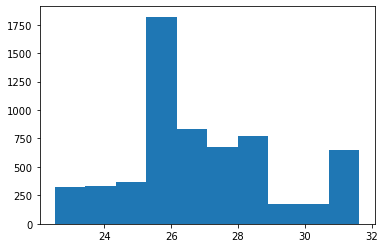

In [106]:
plt.hist(q_list)

In [107]:
left_coverage, coverage, avg_length =  compute_coverage_len(y_val, y_hat_val - q_array, y_hat_val + q_array)
left_coverage_SCP, coverage_SCP, avg_length_SCP =  compute_coverage_len(y_val, y_hat_val - q, y_hat_val + q)

In [108]:
print(f"For SCP: Left coverage:{left_coverage_SCP}, coverage:{coverage_SCP}, and the average length: {avg_length_SCP}")
print(f"For nex-SCP: Left coverage:{left_coverage}, coverage:{coverage}, and the average length: {avg_length}")

For SCP: Left coverage:0.9157257404680085, coverage:0.808214694812633, and the average length: 52.76771545410156
For nex-SCP: Left coverage:0.9171984945180821, coverage:0.8093601701849125, and the average length: 53.82615280151367


In [ ]:
R = 100
SCP = [] #Split conformal prediction
nex_SCP = [] #non-exchangeable Split conformal prediction
alpha = 0.15

lens = []
qs = []
q_lows = []
q_highs = []


for r in range(R):
    val_idx, cal_idx = pre.split_by_group(X=proc_dataset["test"]["X"], groups=proc_dataset["test"]["id"], n_splits=1, test_size=0.5, random_state=r)
    X_val, X_cal = proc_dataset["test"]["X"][val_idx], proc_dataset["test"]["X"][cal_idx]
    y_val, y_cal = proc_dataset["test"]["y"][val_idx], proc_dataset["test"]["y"][cal_idx]
    idx_val, idx_cal = proc_dataset["test"]["index"][val_idx], proc_dataset["test"]["index"][cal_idx]
    id_val, id_cal = proc_dataset["test"]["id"][val_idx], proc_dataset["test"]["id"][cal_idx]

    y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
    y_hat_val = DCNN.predict(x=X_val, verbose=0)

    scores = np.abs(y_cal - y_hat_cal) 


    y_hat_calib = MQDCNN.predict(x=X_calib, verbose=0)
    y_hat_val = MQDCNN.predict(x=X_val, verbose=0)

    scores_low = y_hat_calib[0] - y_calib
    scores_high = y_calib - y_hat_calib[1] 
    scores = np.maximum(scores_low, scores_high)
    q = compute_quantile(scores, alpha)
    q_low = compute_quantile(scores_low, alpha_low)
    q_high = compute_quantile(scores_high, alpha_high)

    lens.append(y_hat_val[1] - y_hat_val[0])
    qs.append(q)
    q_lows.append(q_low)
    q_highs.append(q_high)
    q = compute_quantile(scores, alpha)
    left_coverage, coverage, avg_length =  

    SCP.append(compute_coverage_len(y_val, y_hat_val-q, y_hat_val+q))
    nex_SCP.append(compute_coverage_len(y_val, y_hat_val - q_array, y_hat_val + q_array))

OQ_left_coverage, OQ_coverage, OQ_avg_length = zip(*OQ)
CQ_left_coverage, CQ_coverage, CQ_avg_length = zip(*CQ)
CQLR_left_coverage, CQLR_coverage, CQLR_avg_length = zip(*CQLR)

In [ ]:
alpha = 0.1
epochs = 100 # training epochs
optimizer = Adam(learning_rate=1e-3) # model optimizer
calval_size = 2000 # 2000 of training data is used for cailbration and validation
calib_size = 1000 # 1000 of cailbration+validation data is used for cailbration
val_size = calval_size - calib_size # 1000 of cailbration+validation data is used for validation


X_train, X_calval, y_train, y_calval, idx_train, idx_calval = 

X_train, X_calval, y_train, y_calval, idx_train, idx_calval = train_test_split(X, y, idx, test_size=calval_size, random_state=0)
DCNN = create_model(window_size=30, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

In [10]:
.shape

(2258, 30, 14, 1)

In [ ]:

import numpy as np




In [11]:
import pandas as pd
df = pd.DataFrame(proc_dataset["test"]["X"])

ValueError: Must pass 2-d input. shape=(2258, 30, 14, 1)

In [19]:
split_dataset["train"]

,id,time,os1,os2,os3,sm01,sm02,sm03,sm04,sm05,...,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [21]:
proc_dataset["train"]["X"].shape

(12573, 30, 14, 1)

In [22]:
proc_dataset["train"]["y"].shape

(12573, 1)

In [23]:
proc_dataset["train"]["id"]

array([95, 95, 95, ..., 39, 39, 39], dtype=int64)

In [10]:
proc_dataset["train"]["index"]

array([11255, 11271, 11331, ..., 19961, 19974, 19985], dtype=int64)

In [17]:
proc_dataset["test"]["X"].shape

(3290, 30, 14, 1)

In [26]:
a = dataset["train"].index.values

In [39]:
5*[7]

[7, 7, 7, 7, 7]

In [31]:
import numpy as np
np.hstack([a,b]).shape

(33727,)

In [ ]:
pre.preprocess_split(dataset, **dataset)

In [19]:
g=lambda d: d

In [20]:
g(dataset)

{'name': 'CMAPSS1',
 'train':         id  time     os1     os2    os3    sm01    sm02     sm03     sm04  \
 0        1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
 1        1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
 2        1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
 3        1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
 4        1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
 ...    ...   ...     ...     ...    ...     ...     ...      ...      ...   
 20626  100   196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63   
 20627  100   197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58   
 20628  100   198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18   
 20629  100   199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53   
 20630  100   200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14   
 
         sm05  ...     sm13     s

In [ ]:
f(dataset, **g(dataset))

In [ ]:
def split_dataset(dataset, calval_size=0.2):
    """split data into train and calibration+validation

    Args:
        dataset: a dictionary containing train and test dataframes and their scaler. 
        calval_size (float, optional):  the proportion of the dataset to include in the test split. Defaults to 0.2.

    Returns:
        a dictionary containing train-calval split, train, and test dataframes and their scaler. 
    """
    train_df = dataset["train"]
    test_df = dataset["test"]

    train, calval = train_test_split(train_df, test_size=calval_size, random_state=0, stratify=train_df["id"])
    train_split = dict(train=train, test=calval)

    return {
        **dataset,
        "train_split": train_split,
        "train": train_df,
        "test": test_df
    }

def map_split_dataset(
    f: typing.Callable, dataset: SplitDataset,
    g: typing.Callable = lambda _: dict()) -> SplitDataset:
    return {
        **dataset,
        **f(dataset, **g(dataset)),
        "train_splits": fy.lmap(
            lambda s: f(s, **g(dataset)),
            dataset["train_splits"])
    }